# Operator overloading in python

In [1]:
class Planet:
    def __init__(self, moons):
        self.moons = moons
    
    def __add__(self, newplanet):
        newmoons = self.moons + newplanet.moons
        return Planet(moons=newmoons)

In [2]:
p1 = Planet(['Gany', 'Titan'])
p2 = Planet(['phobo', 'dimo'])

In [3]:
p3 = p1+p2

In [4]:
p3.moons

['Gany', 'Titan', 'phobo', 'dimo']

# GPcore Tests

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
try:
    restartkernel()
except:
    pass

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.append(os.path.abspath('..'))

from condensate.core import gpcore
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




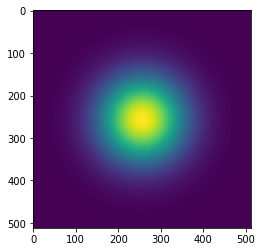

In [23]:
DIM = 512
x = (1+0.j)*np.zeros((DIM,DIM))
V = np.zeros((DIM,DIM))
width = 100
for i in range(DIM):
    for j in range(DIM):
        x[i,j] = np.exp(-( (i-DIM//2)/width)** 2.  -  ((j-DIM//2)/width)** 2. ) + 1.j
        

plt.imshow(np.real(x), vmax = 1, cmap='viridis')
plt.show()

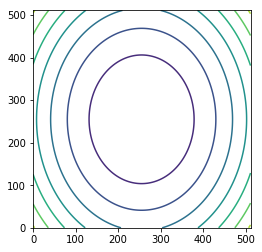

In [27]:
gpcore.Setup(DIM, 1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(1,0.2) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,400,40, True)

In [45]:
steps = 2000
omega = 0.96*np.ones(steps)

In [46]:
gpcore.Setup(DIM, 1e-3,  True, 0)

gpcore.SetHarmonicPotential(1,0) #omega, epsilon
gpcore.RotatingFrame(omega)

gpcore.Evolve(x,steps,40, True)

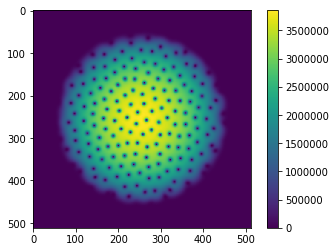

In [37]:
plt.imshow(np.abs(x)**2)
plt.colorbar()

plt.show()

In [ ]:
gpcore.Setup(DIM, 1e-3, False, 0.001)

gpcore.SetHarmonicPotential(1,0.) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,20000,50, True)

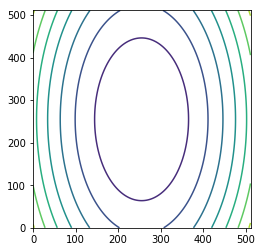

In [7]:
gpcore.Setup(DIM, 1e-3,  True, 0.001)

gpcore.SetHarmonicPotential(1,0.5) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,400,2, True)

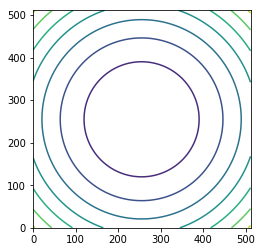

In [6]:
gpcore.Setup(DIM, 1e-3, False, 0.001)

gpcore.SetHarmonicPotential(1,0.) #omega, epsilon
gpcore.GetPotential(V)

plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.show()

gpcore.Evolve(x,20000,50, True)

In [3]:
gpcore.Setup(DIM, 1e-3,  True, 0.001)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,200,4, True)

gpcore.Setup(DIM, 1e-1,  False, 0.001)
gpcore.SetHarmonicPotential(1,0.4) 
gpcore.Evolve(x,9,4, True)

gpcore.Setup(DIM, 1e-3,  False, 0.003)
gpcore.SetHarmonicPotential(1,0) 
gpcore.Evolve(x,20000,50, True)

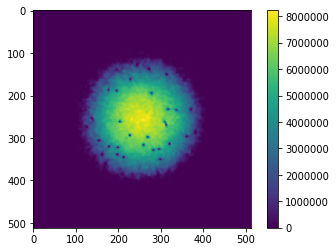

In [38]:
plt.imshow(np.abs(x)**2)
plt.colorbar()

plt.show()

In [39]:
xnew = x.copy()

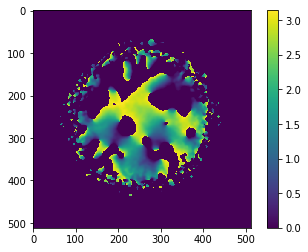

In [40]:
plt.imshow(np.angle(x)* (np.abs(x)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

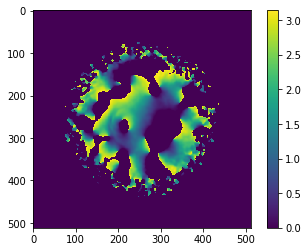

In [41]:
plt.imshow(np.angle(xold)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

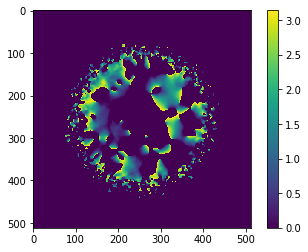

In [42]:
plt.imshow(np.angle(xold/xnew)* (np.abs(xold)**2 >1e4), vmin=0)
plt.colorbar()

plt.show()

In [7]:
dir(gpcore)

['Evolve',
 '__builtin__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_gpcore',
 '_newclass',
 '_object',
 '_swig_getattr',
 '_swig_property',
 '_swig_repr',
 '_swig_setattr',
 '_swig_setattr_nondynamic',
 'cvar',
 'getPotential',
 'setHarmonicPotential',
 'setup']

In [8]:
x = 500e-6
u = 1e-25 * (x**2)

In [10]:
u

2.4999999999999997e-36

## colormap interpolation

In [6]:
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit

def quad(x,a,b,c,d): return d + c*x + b * (x**2) + a * (x**3)

In [7]:
rgb = cm.get_cmap('inferno')
x = np.linspace(0,1,100)
colors = np.array([rgb(xx) for xx in x])

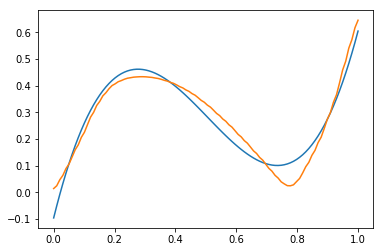

[  7.5327364  -11.43486921   4.60270604  -0.09628023]


In [8]:
channel = 2
f, _  = curve_fit(quad, x, colors[:,channel], [1,1,1,1])
plt.plot(x, quad(x, *f))
plt.plot(x,colors[:,channel])
plt.show()
print(f)